In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.constants as c
import astropy.units as u
from astropy.convolution import convolve
from scipy.optimize import minimize
from p_winds import parker, hydrogen, helium, transit, microphysics, tools

# Uncomment the next line if you have a MacBook with retina screen
# %config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 9.0,6.5
pylab.rcParams['font.size'] = 18

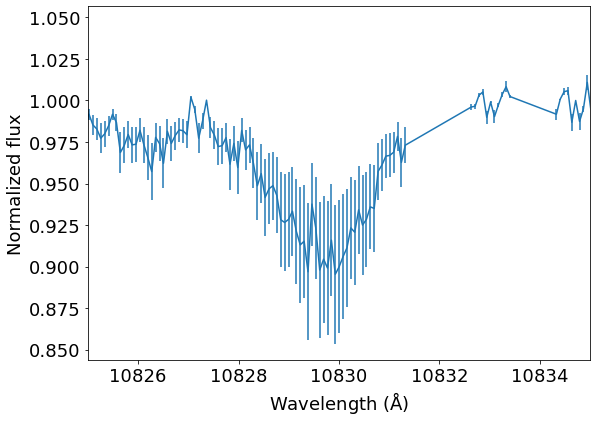

In [6]:
# The observed transmission spectrum
data_url = r'C:\Users\jojoa\GitHub\disperse\data\HPF\HPF_HAT_P_67_20200614_exosphere.txt'
# We skip 2 rows instead of 1 to have an odd number of rows and allow a fast convolution later
He_spec = np.loadtxt(data_url, skiprows=1)
wl_obs = He_spec[:, 0]  # Angstrom
f_obs = 1 - He_spec[:, 1]  # Normalized flux
u_obs = He_spec[:, 2] * 40  # Flux uncertainty

# Convert in-vacuum wavelengths to in-air
s = 1E4 / np.mean(wl_obs)
n = 1 + 0.0000834254 + 0.02406147 / (130 - s ** 2) + 0.00015998 / (38.9 - s ** 2)
wl_obs /= n

# We will also need to know the instrumental profile that
# widens spectral lines. We take the width from Allart et al. (2018),
# the paper describing the HAT-P-11 b data.
def gaussian(x, mu=0.0, sigma=1.0):
    return 1 / sigma / (2 * np.pi) ** 0.5 * np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

instrumental_profile_width_v = 3.7  # Instrumental profile FWHM in km / s (assumed Gaussian)
sigma_wl = instrumental_profile_width_v / (2 * (2 * np.log(2)) ** 0.5) / \
    c.c.to(u.km / u.s).value * np.mean(wl_obs)  # Same unit as wl_obs
instrumental_profile = gaussian(wl_obs, np.mean(wl_obs), sigma=sigma_wl)

plt.errorbar(wl_obs, f_obs, yerr=u_obs)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel('Normalized flux')
plt.xlim(10825,10835)
plt.show()

In [29]:
# Set up the simulation

# Fixed parameters of HAT-P-67 b (not to be sampled)
R_pl = 2.085  # Planetary radius in Jupiter radii
M_pl = 0.34  # Planetary mass in Jupiter masses
impact_parameter = 0.12  # Transit impact parameter (+.12 -.08)
a_pl = 0.06505  # Semi-major axis (au)
planet_to_star_ratio = 0.08087396863
h_fraction = 0.90  # H number fraction
he_fraction = 1 - h_fraction  # He number fraction
he_h_fraction = he_fraction / h_fraction
mean_f_ion = 0.90  # Initially assumed, but the model relaxes for it
mu_0 = (1 + 4 * he_h_fraction) / (1 + he_h_fraction + mean_f_ion)  
# mu_0 is the constant mean molecular weight (assumed for now, will be updated later)

# Physical constants
m_h = c.m_p.to(u.g).value  # Hydrogen atom mass in g
m_He = 4 * 1.67262192369e-27  # Helium atomic mass in kg
k_B = 1.380649e-23  # Boltzmann's constant in kg / (m / s) ** 2 / K

# Free parameters (to be sampled with the optimization algorithm)
# The reason why we set m_dot and T in log is because
# we will fit for them in log space
log_m_dot_0 = np.log10(10**12)  # Planetary mass loss rate (g / s)
log_T_0 = np.log10(4000)  # Atmospheric temperature (K)
v_wind_0 = -10*10**3  # Line-of-sight wind velocity (m / s)

# Altitudes samples (this can be a very important setting)
r = np.logspace(0, np.log10(20), 100)

# First guesses of fractions (not to be fit, but necessary for the calculation)
initial_f_ion = 0.0  # Fraction of ionized hydrogen
initial_f_he = np.array([1.0, 0.0])  # Fraction of singlet, triplet helium

# Model settings
relax_solution = True  # This will iteratively relax the solutions until convergence
exact_phi = True  # Exact calculation of H photoionization
sample_phases = np.linspace(-0.50, 0.50, 5)  # Phases that we will average to obtain the final spectrum
# The phases -0.5 and +0.5 correspond to the times of first and fourth transit contact
w0, w1, w2, f0, f1, f2, a_ij = microphysics.he_3_properties()
w_array = np.array([w0, w1, w2])  # Central wavelengths of the triplet
f_array = np.array([f0, f1, f2])  # Oscillator strengths of the triplet
a_array = np.array([a_ij, a_ij, a_ij])  # This is the same for all lines in then triplet
n_samples = len(sample_phases)
transit_grid_size = 100  # Also very important to constrain computation time
supersampling = 5  # This is used to improve the hard pixel edges in the ray tracing

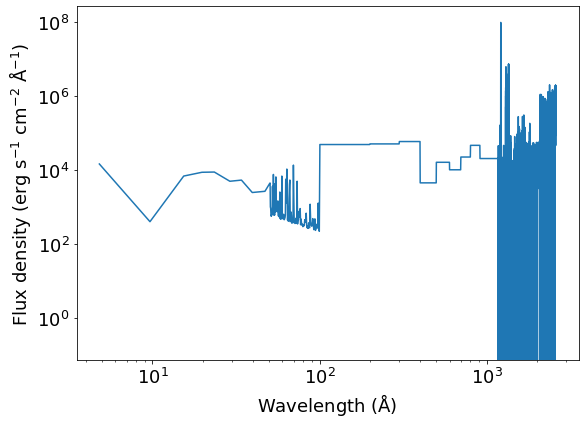

In [34]:
data_url = 'https://gist.githubusercontent.com/ladsantos/c7d1aae1ecc755bae9f1c8ef1545cf8d/raw/cb444d9b4ff9853672dab80a4aab583975557449/HAT-P-11_spec.dat'
spec = np.loadtxt(data_url, skiprows=1)
host_spectrum = {'wavelength': spec[:, 0], 'flux_lambda': spec[:, 1],
                 'wavelength_unit': u.angstrom,
                 'flux_unit': u.erg / u.s / u.cm ** 2 / u.angstrom}
host_spectrum['flux_lambda'] = host_spectrum['flux_lambda']*1000

plt.loglog(host_spectrum['wavelength'], host_spectrum['flux_lambda'])
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel(r'Flux density (erg s$^{-1}$ cm$^{-2}$ ${\rm \AA}^{-1}$)')
plt.show()

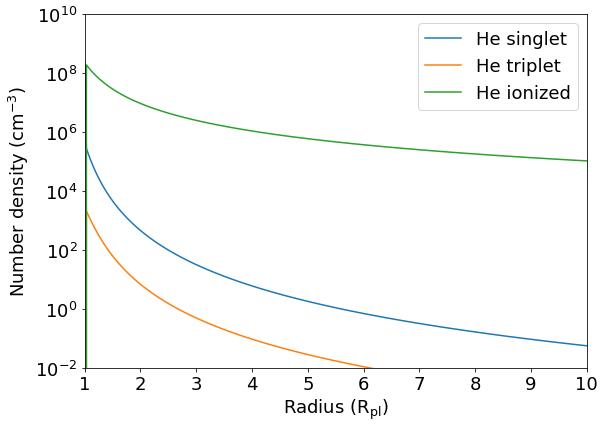

In [35]:
#Calculate the model
def atmospheric_model(theta):
    log_m_dot, log_T = theta
    m_dot = 10 ** log_m_dot
    T = 10 ** log_T
    
    f_r, mu_bar = hydrogen.ion_fraction(r, R_pl, T, h_fraction,
                                m_dot, M_pl, mu_0,
                                spectrum_at_planet=host_spectrum,
                                initial_f_ion=initial_f_ion, 
                                relax_solution=relax_solution,
                                exact_phi=exact_phi, return_mu=True)

    # Update the structure for the revised ion fraction
    updated_mean_f_ion = np.mean(f_r)
    vs = parker.sound_speed(T, mu_bar)
    rs = parker.radius_sonic_point(M_pl, vs)
    rhos = parker.density_sonic_point(m_dot, rs, vs)
    r_array = r * R_pl / rs
    v_array, rho_array = parker.structure(r_array)
    
    # Calculate the helium population
    f_he_1, f_he_3 = helium.population_fraction(r, v_array, rho_array, f_r,
        R_pl, T, h_fraction, vs, rs, rhos,
        spectrum_at_planet=host_spectrum,
        initial_state=initial_f_he, relax_solution=relax_solution)

    # Number density of helium nuclei
    n_he = (rho_array * rhos * he_fraction / (1 + 4 * he_fraction) / m_h)
    
    # Number density distribution of helium
    n_he_1 = f_he_1 * n_he
    n_he_3 = f_he_3 * n_he
    n_he_ion = (1 - f_he_1 - f_he_3) * n_he
    
    # Return the important outputs (number densities [cm ** -3] of helium and 
    # the profile of velocities of the outflow [km / s])
    return n_he_1, n_he_3, n_he_ion, v_array * vs

# Let's test if the model function is working
theta = (log_m_dot_0, log_T_0)
y0 = (initial_f_ion, initial_f_he)
n_he_1, n_he_3, n_he_ion, v_array = atmospheric_model(theta)

plt.semilogy(r, n_he_1, color='C0', label='He singlet')
plt.semilogy(r, n_he_3, color='C1', label='He triplet')
plt.semilogy(r, n_he_ion, color='C2', label='He ionized')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-2, 1E10)
plt.legend()
plt.show()

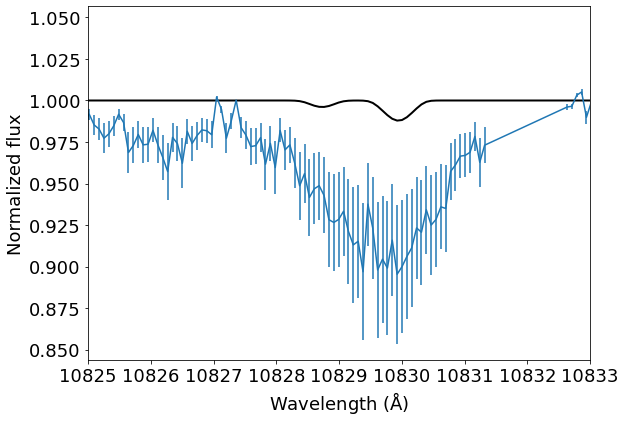

In [36]:
# The transmission spectrum model
def transmission_model(wavelength_array, v_wind, n_he_3_distribution, log_T, v_array):

    # Set up the transit configuration. We use SI units to avoid too many 
    # headaches with unit conversion
    R_pl_physical = R_pl * 71492000  # Planet radius in m
    r_SI = r * R_pl_physical  # Array of altitudes in m
    v_SI = v_array * 1000  # Velocity of the outflow in m / s
    n_he_3_SI = n_he_3_distribution * 1E6  # Volumetric densities in 1 / m ** 3

    # Set up the ray tracing
    f_maps = []
    t_depths = []
    r_maps = []
    for i in range(n_samples):
        flux_map, transit_depth, r_map = transit.draw_transit(
            planet_to_star_ratio,
            impact_parameter=impact_parameter,
            supersampling=supersampling,
            phase=sample_phases[i],
            planet_physical_radius=R_pl_physical,
            grid_size=transit_grid_size
                                   )
        f_maps.append(flux_map)
        t_depths.append(transit_depth)
        r_maps.append(r_map)
    # Do the radiative transfer
    spectra = []

    for i in range(n_samples):
        spec = transit.radiative_transfer_2d(f_maps[i], r_maps[i], 
                                        r_SI, n_he_3_SI, v_SI, w_array, f_array, a_array,
                                        wavelength_array, 10 ** log_T, m_He, bulk_los_velocity=v_wind,
                                            wind_broadening_method='average')
        # We add the transit depth because ground-based observations
        # lose the continuum information and they are not sensitive to
        # the loss of light by the opaque disk of the planet, only
        # by the atmosphere
        spectra.append(spec + t_depths[i])

    spectra = np.array(spectra)
    # Finally we take the mean of the spectra we calculated for each phase
    spectrum = np.mean(spectra, axis=0)
    return spectrum

# Here we divide wl_obs by 1E10 to convert angstrom to m
t_spectrum = transmission_model(wl_obs / 1E10, v_wind_0, n_he_3, log_T_0, v_array)
plt.errorbar(wl_obs, f_obs, yerr=u_obs)
plt.plot(wl_obs, t_spectrum, color='k', lw=2)
plt.xlim(10825,10833)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel('Normalized flux')
plt.show()

In [ ]:
def cascading_model(theta, wavelength_array):
    log_m_dot, log_T, v_wind = theta
    n_he_1, n_he_3, n_he_ion, v = atmospheric_model((log_m_dot, log_T))
    t_spec = transmission_model(wavelength_array, v_wind, n_he_3, log_T, v)
    t_spec_conv = convolve(t_spec, instrumental_profile, boundary='extend')
    return t_spec_conv

# First guess
theta0 = (log_m_dot_0, 
          log_T_0, 
          v_wind_0)

t_spec = cascading_model(theta0, wl_obs / 1E10)

plt.errorbar(wl_obs, f_obs, yerr=u_obs)
plt.plot(wl_obs, t_spec, color='k', lw=2)
plt.xlim(10825,10835)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel('Normalized flux')
plt.show()

In [ ]:
def log_likelihood(theta, x, y, yerr):
    try:
        model = cascading_model(theta, x)
        sigma2 = yerr ** 2
        return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
    except RuntimeError:
        return -np.inf

In [ ]:
nll = lambda *args: -log_likelihood(*args)
args = (wl_obs / 1E10, f_obs, u_obs)
# %time soln = minimize(nll, theta0, args=args, method='Nelder-Mead')
# log_mdot_ml, logT_ml, v_wind_ml = soln.x

In [ ]:
theta_ml = (np.log10(4.9E10), np.log10(8100), -1.9E3)

t_spec = cascading_model(theta_ml, wl_obs / 1E10)

plt.errorbar(wl_obs, f_obs, yerr=u_obs)
plt.plot(wl_obs, t_spec, color='k', lw=2)
plt.xlim(10825,10835)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel('Normalized flux')
plt.show()